In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# Загружаем
#df = pd.read_csv("data/merged2.csv")
#df.drop("Unnamed: 0", axis=1)
df = pd.read_csv("data/merged_freight_oil.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Сохраняем Date для графика
df["Date_orig"] = df["Date"]

# Добавляем признаки
df["month"] = df["Date"].dt.month / 12
df["year"] = (df["Date"].dt.year - df["Date"].dt.year.min()) / 10
df["oil_lag1"] = df["Oil_Price"].shift(1)
df["oil_roll3"] = df["Oil_Price"].rolling(window=3).mean()

# Удаляем пропуски
df = df.dropna().reset_index(drop=True)

In [3]:
# Фичи для модели
features = ["Freight_Price", "Oil_Price", "month", "year", "oil_lag1", "oil_roll3"]
data = df[features].values.astype(np.float32)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len, 0]  # Freight_Price
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs), torch.tensor(ys)

seq_len = 12
X, y = create_sequences(data_scaled, seq_len)

# Делим на train/test
X_train, y_train = X[:-48], y[:-48]
X_test_start = data_scaled[-(48 + seq_len):]

C:\Users\Admin\AppData\Local\Temp\ipykernel_5776\4080602877.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(xs), torch.tensor(ys)


In [4]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1]).squeeze()

input_size = X.shape[2]
model = LSTMForecast(input_size=input_size)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")

[Epoch 0] Loss: 0.2169
[Epoch 10] Loss: 0.0701
[Epoch 20] Loss: 0.0398
[Epoch 30] Loss: 0.0177
[Epoch 40] Loss: 0.0124


In [6]:
model.eval()
input_seq = torch.tensor(X_test_start[:seq_len]).unsqueeze(0)
predictions = []

with torch.no_grad():
    for i in range(48):
        pred = model(input_seq).item()
        next_known = X_test_start[seq_len + i, 1:]  # всё кроме Freight_Price
        new_entry = torch.tensor([[pred, *next_known]])
        input_seq = torch.cat([input_seq[:, 1:], new_entry.unsqueeze(0)], dim=1)
        predictions.append(pred)

In [7]:
# === forecast
oil = X_test_start[seq_len:, 1].reshape(-1, 1)
month = X_test_start[seq_len:, 2].reshape(-1, 1)
year = X_test_start[seq_len:, 3].reshape(-1, 1)
lag = X_test_start[seq_len:, 4].reshape(-1, 1)
roll = X_test_start[seq_len:, 5].reshape(-1, 1)
pred_arr = np.array(predictions).reshape(-1, 1)
forecast_combined = np.hstack((pred_arr, oil, month, year, lag, roll))
forecast_prices = scaler.inverse_transform(forecast_combined)[:, 0]

# === true значения
true_prices = data[-48:, 0]

# === train
oil = X_train[:, -1, 1].unsqueeze(1).numpy()
month = X_train[:, -1, 2].unsqueeze(1).numpy()
year = X_train[:, -1, 3].unsqueeze(1).numpy()
lag = X_train[:, -1, 4].unsqueeze(1).numpy()
roll = X_train[:, -1, 5].unsqueeze(1).numpy()
train_combined = np.hstack((y_train.numpy().reshape(-1, 1), oil, month, year, lag, roll))
train_pred_prices = scaler.inverse_transform(train_combined)[:, 0]


C:\Users\Admin\AppData\Local\Temp\ipykernel_5776\3215007605.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


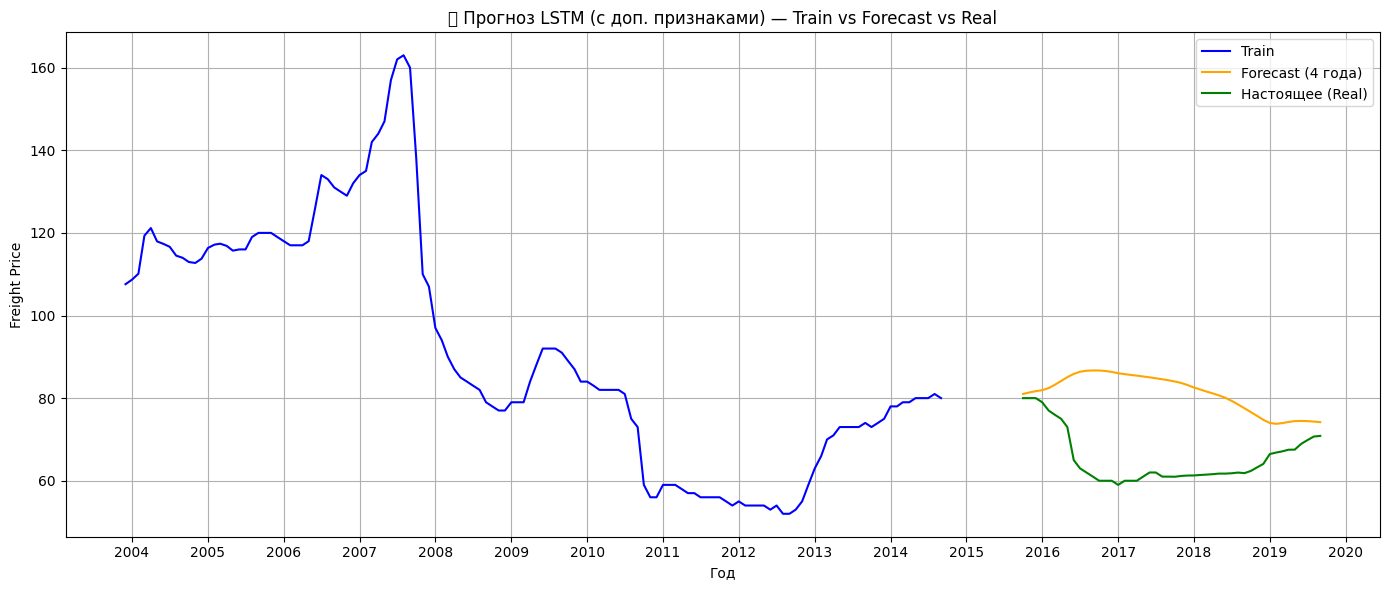

In [8]:
forecast_dates = df["Date_orig"].iloc[-48:].values
train_dates = df["Date_orig"].iloc[:len(y_train)].values
test_dates = df["Date_orig"].iloc[-48:].values

plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_pred_prices, label="Train", color="blue")
plt.plot(test_dates, forecast_prices, label="Forecast (4 года)", color="orange")
plt.plot(test_dates, true_prices, label="Настоящее (Real)", color="green")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Год")
plt.ylabel("Freight Price")
plt.title("📊 Прогноз LSTM (с доп. признаками) — Train vs Forecast vs Real")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()